## 14-1. 프로젝트 : Segmentation map으로 도로 이미지 만들기

데이터셋을 이용해 Pix2Pix를 학습시켜보기</br>

- [cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

**프로젝트 수행**

---

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같다.</br>

    1. 데이터에 한 가지 이상의 **augmentation 방법**을 적용하여 학습해 주세요.</br>
    (어떠한 방법을 사용했는지 적어주세요.)
    2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**해 주세요.
    3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
    4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
    5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

아래의 기준을 바탕으로 프로젝트를 평가합니다.</br>

<table>
    <tr>
        <td><b>평가문항</b></td>
        <td><b>상세기준</b></td>
    </tr>
    <tr>
        <td>1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.</td>
        <td>데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.</td>
    </tr>
    <tr>
        <td>2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.</td>
        <td>U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.</td>
    </tr>
    <tr>
        <td>3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.</td>
        <td>10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 저오의 품질을 확인하였다.</td>
    </tr>
</table>

In [1]:
# 모듈 임포트
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model

from tensorflow.keras import losses
from tensorflow.keras import optimizers

import os
import pathlib

In [2]:
# 파일 다운로드
_URL = "https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip"
dataset_name = "cityscapes"

# tf.keras.utils.get_file()
# URL에서 파일 정보 가져와서 $HOME/.keras/datasets/target_file.zip 위치에 cache로 저장
path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30195712/30179339 [==============================] - 0s 0us/step


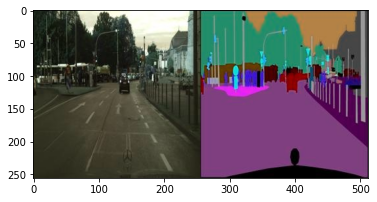

In [3]:
# 데이터 1장씩 확인(train, val)
train_path = os.path.join(str(PATH), "train/")
val_path = os.path.join(str(PATH), "val/")

f = train_path + os.listdir(train_path)[1]
img = cv2.imread(f, cv2.IMREAD_COLOR)

plt.imshow(img)

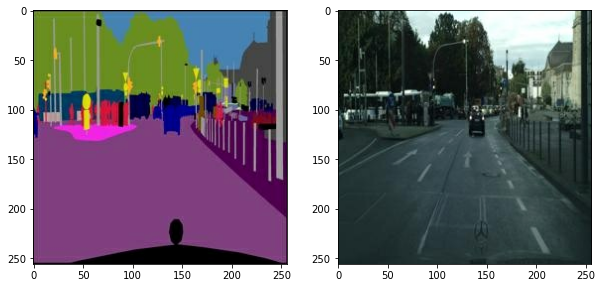

In [4]:
# 이미지 전처리를 위한 함수 선언
# input_image, real_image를 데이터셋(f)에서 획득
## denormalize() 함수 사용하여 나온 결과 확인
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [5]:
# Augmentation 적용
@tf.function()  # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(sketch, colored):
    # 이미지 합치기; 3채널의 이미지 두 개를 6채널의 이미지 하나로 합침
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 50% 미만의 확률로 (if 부분) Reflection padding 적용
    # 반대의 경우엔 Constant padding 적용
    ## 위 두 내역은 padded에 반영됨

    # 이미지를 랜덤하게 자름(crop)
    out = image.random_crop(padded, size=[256, 256, 6])
    # 이미지를 좌우반전시킴
    out = image.random_flip_left_right(out)
    # 이미지를 상하반전시킴
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        # 이미지를 50% 미만 확률로 회전시킴(image.rot90)
        # k 인자는 회전 시 몇번 회전하였는가를 결정함
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

In [6]:
# 이미지를 불러 `load_img()` Augmentation을 적용 시킨 후 sketch, colored 이미지를 반환하는 함수 선언
def get_img(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [7]:
# 훈련 데이터셋의 이미지를 나누고 augmentation 적용
train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_img).shuffle(100).batch(4)

In [8]:
# U-Net Generator 구성을 위한 Blocks 설정

# Encode-block 설정
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

# Decode-block 설정    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
# 위에서 선언한 Block 들을 활용하여 U-Net Generator 구성
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
# Discriminator 구성을 위한 DiscBlock 선언
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [11]:
# DiscBlock()을 이용하여 Discriminator 클래스 선언
## 내부 인코딩(Block append)은 for문으로 구현
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.

        # DiscBlock에 필요한 arguments 초기값 설정
        n_filters, stride = None, None  # type setting as int, int
        custom_pad, use_bn, act = None, None, None # type setting as Bool, Bool, Bool

        for idx_of_filters in range(len(filters)):
            # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
            # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
            if idx_of_filters < 3:
                stride = 2
                custom_pad = False
            else:
                stride = 1
                custom_pad = True
            # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.    
            if idx_of_filters == 0 or idx_of_filters == 4:
                use_bn = False
            else:
                use_bn = True
            # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요.
            if idx_of_filters <= 3:
                act = True
            else:
                act = False
            
            # flters 순서대로 n_filters의 값을 적용; 조건과 무관함
            n_filters = filters[idx_of_filters]

            # DiscBlock() appending; self.blocks의 길이를 늘리자
            self.blocks.append(DiscBlock(n_filters=n_filters, stride=stride, 
                    custom_pad=custom_pad, use_bn=use_bn, act=act))

        ## (sigmoid의 경우 따로 정의해야 합니다)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        # Block 통과한 출력값 out 초기화
        out = None
        # __init__()에서 쌓은 blocks를 local var로 가져와보자
        blocks = self.blocks

        # list인 blocks를 순회
        for idx_of_blocks in range(len(blocks)):
            if idx_of_blocks == 0:
                # blocks[0] == layers.Concatenate()
                out = blocks[idx_of_blocks]([x, y])
            else:
                out = blocks[idx_of_blocks](out)
        
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

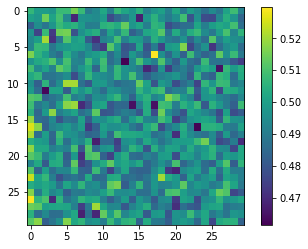

In [12]:
# 256 x 256 RGB 이미지 랜덤생성 해서 Discriminator 적용
# imshow()를 통해 적용된 이미지 확인
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [13]:
# 손실함수 선언
# GAN loss와 L1 loss가 둘다 적용된 것이 논문에서 결과가 좋아서 이렇게 생성하였음
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [14]:
# Optimizer 선언
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [15]:
# 하나의 배치가 입력되면 가중치를 1회 업데이트하는 함수 선언
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        # 논문 기준 L1 Loss값에 λ값을 곱하는 수식이 있음; λ = 100
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [16]:
# 10 epoch의 학습 진행
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]} # loss 값 시각화를 위해 생성

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
            
            
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0257                     
L1_loss:0.3645                     
Discriminator_loss:1.2860

EPOCH[1] - STEP[20]                     
Generator_loss:0.8886                     
L1_loss:0.2575                     
Discriminator_loss:1.1614

EPOCH[1] - STEP[30]                     
Generator_loss:0.9430                     
L1_loss:0.2075                     
Discriminator_loss:1.3142

EPOCH[1] - STEP[40]                     
Generator_loss:0.8315                     
L1_loss:0.2264                     
Discriminator_loss:1.4592

EPOCH[1] - STEP[50]                     
Generator_loss:1.0506                     
L1_loss:0.2233                     
Discriminator_loss:1.0602

EPOCH[1] - STEP[60]                     
Generator_loss:0.7570                     
L1_loss:0.1870                     
Discriminator_loss:1.4120

EPOCH[1] - STEP[70]                     
Generator_loss:0.8733                     
L1_loss:0.1761                    

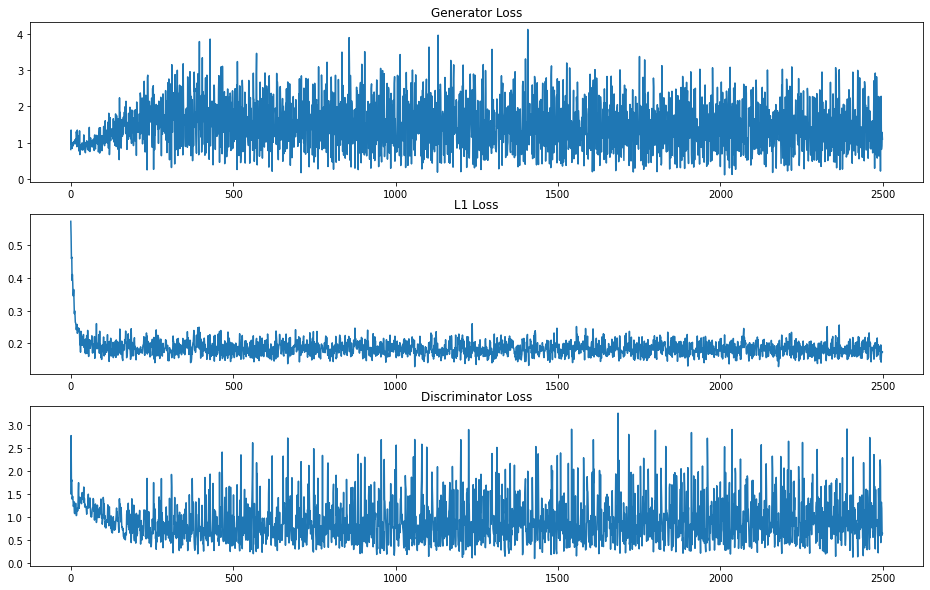

In [17]:
# loss 값 시각화
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

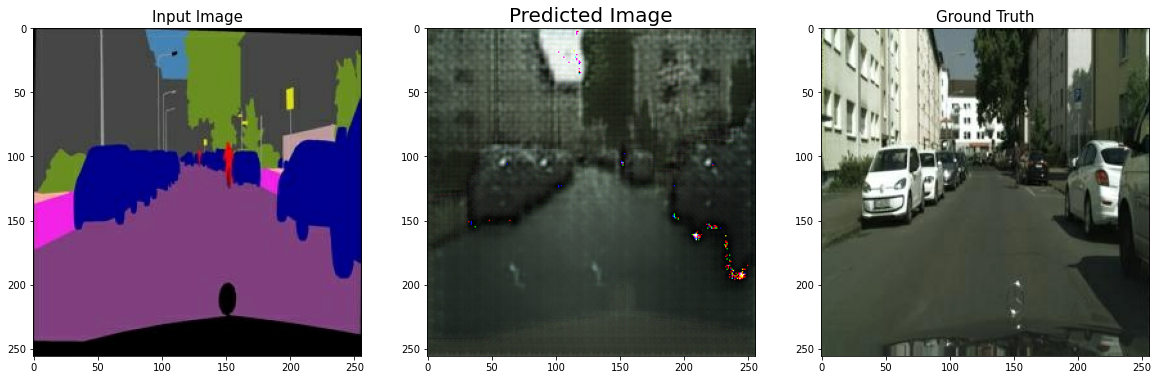

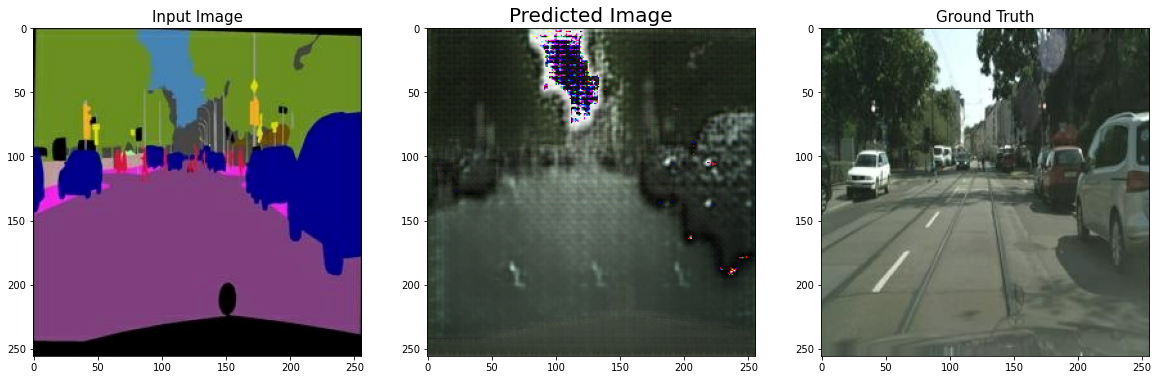

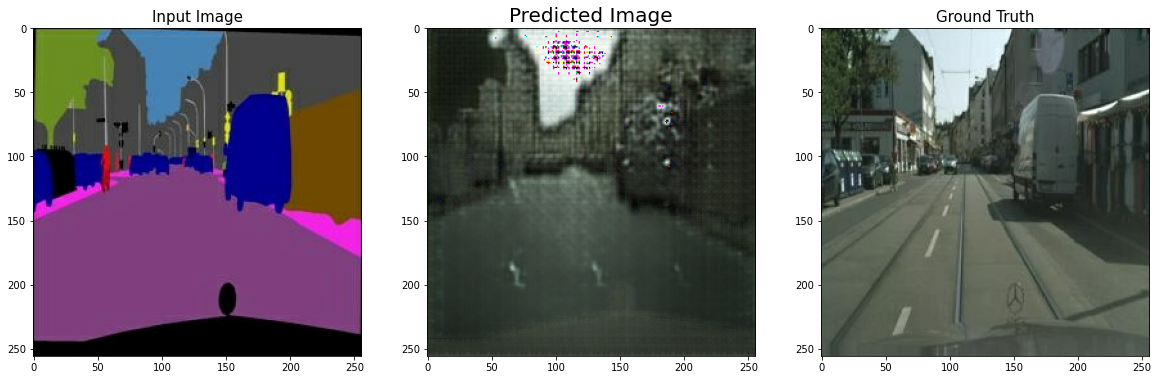

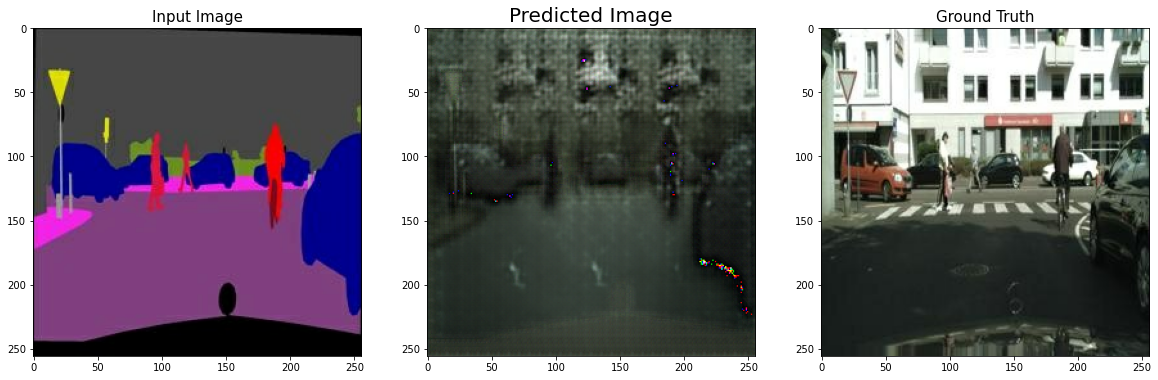

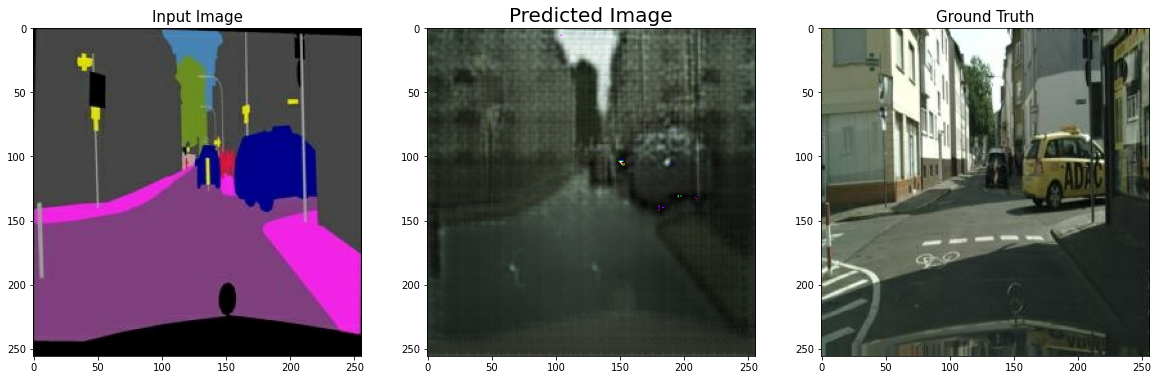

In [18]:
# 이미지 denormalize하여 확인하기
for val_image in os.listdir(val_path):
    f = os.path.join(val_path, val_image)
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)